In [1]:
import os
from mplsoccer.pitch import Pitch, add_image
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import NMF
from PIL import Image
from urllib.request import urlopen

Load data

In [2]:
df = pd.read_parquet(os.path.join('..', 'data', 'shots.parquet'))

mplsoccer pitch for plotting/ binning data

In [3]:
pitch = Pitch(pitch_type='statsperform', orientation='vertical', view='half',
              pad_left=-5, pad_right=-5, pad_bottom=-10, line_zorder=2, figsize=(16, 9))

Subset shots from players with more than 50 shots

In [4]:
shot_stats = df.player_id.value_counts()
player_ids = shot_stats[shot_stats >= 50].index
df = df[df.player_id.isin(player_ids)].copy()
print('Number of shots:', len(df))
n_players = len(player_ids)
print('Number of players:', n_players)

Number of shots: 27274
Number of players: 298


Overall shot map. Binning approximately 2 metre square grid. Count of shots in each grid cell.

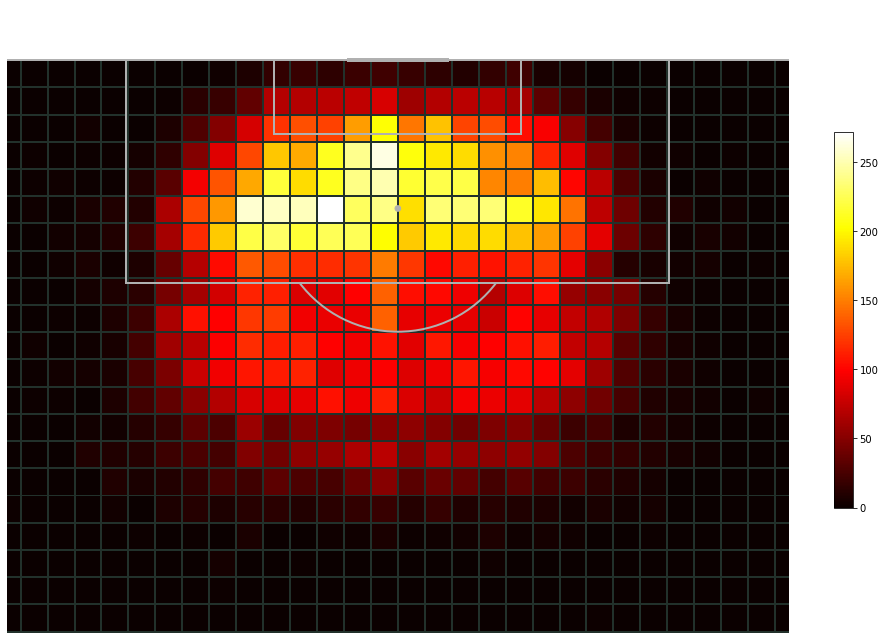

In [5]:
fig, ax = pitch.draw()
bs = pitch.bin_statistic(df.x, df.y, statistic='count', bins=(52, 34))
pcm = pitch.heatmap(bs, ax=ax, cmap='hot', edgecolors='#22312b')
fig.colorbar(pcm, fraction=0.045, pad=0.04, shrink=0.6)

Bin Statistics for each player, smoothed with gaussian filter

In [6]:
results = np.zeros((n_players, 34 * 52))
for i in range(n_players):
    df_player = df[df.player_id == player_ids[i]]
    bs = pitch.bin_statistic(df_player.x, df_player.y, statistic='count', bins=(52, 34))
    results[i] = gaussian_filter(bs['statistic'], 3).flatten()

Non-negative matrix factorisation

In [7]:
m = NMF(n_components=5, init='random', random_state=42)
matrix = m.fit_transform(results)
df_matrix = pd.DataFrame(matrix, index=player_ids)
H = m.components_

Load StatsBomb logo

In [8]:
IMAGE_URL = 'https://github.com/statsbomb/open-data/blob/master/stats-bomb-logo.png?raw=true'
logo = np.array(Image.open(urlopen(IMAGE_URL)))

Plot components

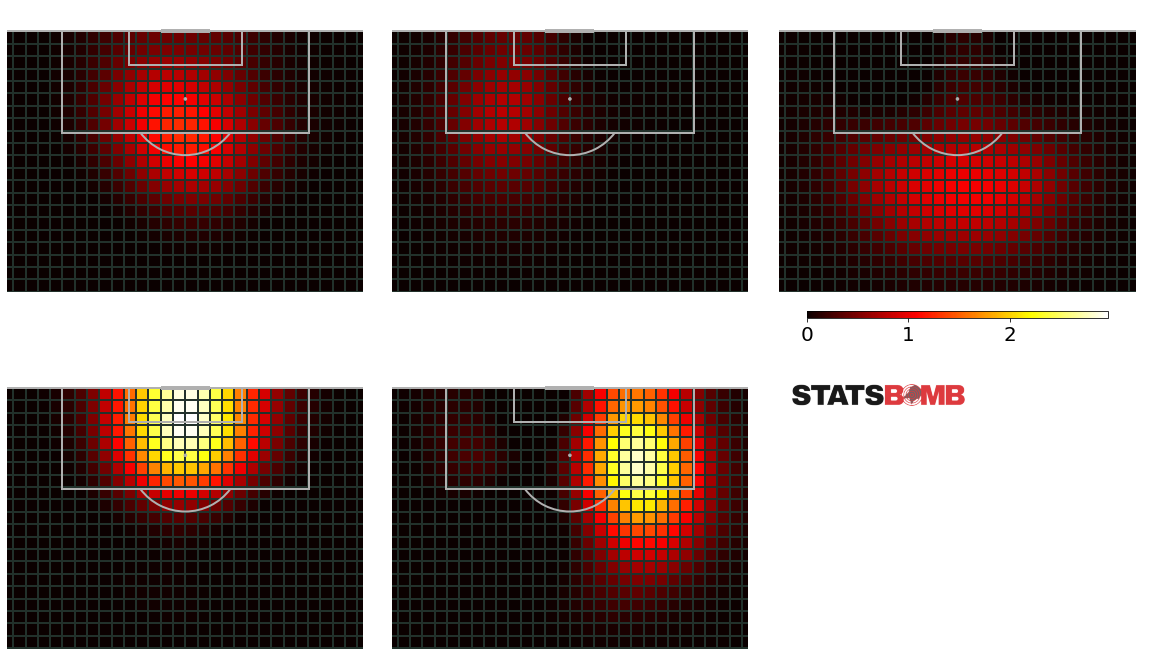

In [81]:
pitch = Pitch(pitch_type='statsperform', orientation='vertical', view='half',
              pad_left=-5, pad_right=-5, pad_bottom=-10, line_zorder=2, figsize=(16, 9),
             layout=(2, 3), tight_layout=False, constrained_layout=True)
fig, axs = pitch.draw()
axs[1, 2].remove()

bs['statistic'] = H[0].reshape(34, 52)
pcm = pitch.heatmap(bs, ax=axs[0, 0], cmap='hot', edgecolors='#22312b', vmin=H.min(), vmax=H.max())

bs['statistic'] = H[1].reshape(34, 52)
pcm = pitch.heatmap(bs, ax=axs[0, 1], cmap='hot', edgecolors='#22312b', vmin=H.min(), vmax=H.max())

bs['statistic'] = H[2].reshape(34, 52)
pcm = pitch.heatmap(bs, ax=axs[0, 2], cmap='hot', edgecolors='#22312b', vmin=H.min(), vmax=H.max())

bs['statistic'] = H[3].reshape(34, 52)
pcm = pitch.heatmap(bs, ax=axs[1, 0], cmap='hot', edgecolors='#22312b', vmin=H.min(), vmax=H.max())

bs['statistic'] = H[4].reshape(34, 52)
pcm = pitch.heatmap(bs, ax=axs[1, 1], cmap='hot', edgecolors='#22312b', vmin=H.min(), vmax=H.max())

cbar = fig.colorbar(pcm, ax=[axs[0, 2]], location='bottom', shrink=0.8)
cbar.ax.tick_params(labelsize=20) 

ax_image = add_image(logo, fig, left=0.69, bottom=0.38, width=0.15, alpha=0.9, interpolation='hanning')

fig.savefig('non-negative.png', dpi=300, bbox_inches = 'tight', pad_inches = 0)